In [21]:
import pandas as pd
import numpy as np
import seaborn as sns

In [12]:
data = pd.read_csv("./output/sars_cov2_mpro_ic50_clean.csv").drop(["Unnamed: 0", "index"], axis=1)

In [13]:
data.head(3)

,molecule_pref_name,canonical_smiles,molecule_chembl_id,standard_value,standard_units,molecule_id
0,PHENACYL CHLORIDE,O=C(CCl)c1ccccc1,CHEMBL105712,190.0,nM,105712
1,BENSERAZIDE,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,CHEMBL1096979,140.0,nM,1096979
2,2-MERCAPTOBENZOTHIAZOLE,Sc1nc2ccccc2s1,CHEMBL111654,1740.0,nM,111654


## Categorize Active vs Inactive
IC50 < 1000 nM = Active else Inactive

In [23]:
data['class'] = data["standard_value"].apply(lambda x: ("active" if x <= 1000  else "inactive")).astype("category")
data.head()

,molecule_pref_name,canonical_smiles,molecule_chembl_id,standard_value,standard_units,molecule_id,class
0,PHENACYL CHLORIDE,O=C(CCl)c1ccccc1,CHEMBL105712,190.0,nM,105712,active
1,BENSERAZIDE,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,CHEMBL1096979,140.0,nM,1096979,active
2,2-MERCAPTOBENZOTHIAZOLE,Sc1nc2ccccc2s1,CHEMBL111654,1740.0,nM,111654,inactive
3,NaN,O=C(O)c1ccc(SSc2ccc(C(=O)O)cn2)nc1,CHEMBL1161936,240.0,nM,1161936,active
4,NaN,C/N=c1/nc(-c2ccccc2)n(-c2ccccc2)s1,CHEMBL1188627,980.0,nM,1188627,active


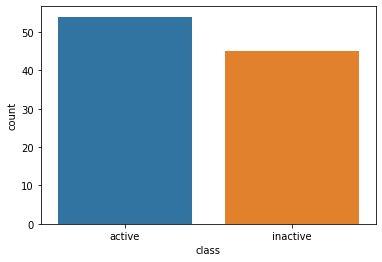

In [24]:
# Visualize
ax = sns.countplot(x="class", data=data)

## Normalize IC50 data => nIC50
**Standard Cited procedure**: Apply -log(Molar Concentration)

In [26]:
def norm_ic50(ic50):
    ic50_moles = ic50 * (10**-9) # Convert Molar to Nano Molar
    return -1* np.log10(ic50_moles)

data['nIC50'] =  data['standard_value'].apply(norm_ic50)
data.head()

,molecule_pref_name,canonical_smiles,molecule_chembl_id,standard_value,standard_units,molecule_id,class,nIC50
0,PHENACYL CHLORIDE,O=C(CCl)c1ccccc1,CHEMBL105712,190.0,nM,105712,active,6.721246
1,BENSERAZIDE,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,CHEMBL1096979,140.0,nM,1096979,active,6.853872
2,2-MERCAPTOBENZOTHIAZOLE,Sc1nc2ccccc2s1,CHEMBL111654,1740.0,nM,111654,inactive,5.759451
3,NaN,O=C(O)c1ccc(SSc2ccc(C(=O)O)cn2)nc1,CHEMBL1161936,240.0,nM,1161936,active,6.619789
4,NaN,C/N=c1/nc(-c2ccccc2)n(-c2ccccc2)s1,CHEMBL1188627,980.0,nM,1188627,active,6.008774


In [27]:
data['nIC50'].describe()

count    99.000000
mean      6.167278
std       0.639799
min       5.302771
25%       5.628010
50%       6.075721
75%       6.657577
max       8.000000
Name: nIC50, dtype: float64

# Calculate Lipinski and Related Descriptors

In [32]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors, Descriptors, QED
from rdkit.Chem.Draw import IPythonConsole

In [36]:
def compute_descriptors(row):
    try:
        mol = Chem.MolFromSmiles(row["canonical_smiles"])
    
        row["logP"] = Descriptors.MolLogP(mol)
        row['molecular_wt'] = Descriptors.MolWt(mol)
        row['havy_atom_count'] = Descriptors.HeavyAtomCount(mol)
        row["hydrogen_acceptors"] = Descriptors.NumHAcceptors(mol)
        row["hydrogen_donors"] = Descriptors.NumHDonors(mol)
        row["rotatable_bonds"] = Descriptors.NumRotatableBonds(mol)
        row["amide_bonds"] = rdMolDescriptors.CalcNumAmideBonds(mol)
        row["ring_count"] = Descriptors.RingCount(mol)
        row["tpsa"]  = Descriptors.TPSA(mol)
        row["hba"]   = rdMolDescriptors.CalcNumHBA(mol)
        row["hbd"]  = rdMolDescriptors.CalcNumHBD(mol)
        row["qed"]   = QED.qed(mol)
    except:
        print("Error Creating Molecules")
    
    return row
    

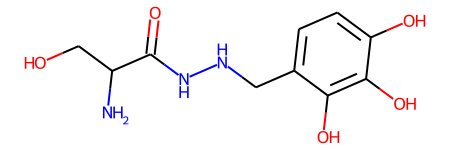

In [31]:
# Demo
sample_data = data.iloc[1]
mol = Chem.MolFromSmiles(sample_data.canonical_smiles)
display(mol)

In [39]:
compute_descriptors(sample_data)

<ipython-input-36-e9b20c8271dc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row["logP"] = Descriptors.MolLogP(mol)
<ipython-input-36-e9b20c8271dc>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['molecular_wt'] = Descriptors.MolWt(mol)
<ipython-input-36-e9b20c8271dc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['havy_atom_count'] = Descriptors.HeavyAtomCount(mol)
<ipython-input-36-e9b20c8271dc>:8: SettingWithCopyWarni

molecule_pref_name                      BENSERAZIDE
canonical_smiles      NC(CO)C(=O)NNCc1ccc(O)c(O)c1O
molecule_chembl_id                    CHEMBL1096979
standard_value                                140.0
standard_units                                   nM
molecule_id                                 1096979
class                                        active
nIC50                                      6.853872
logP                                        -1.7562
molecular_wt                                257.246
havy_atom_count                                  18
hydrogen_acceptors                                7
hydrogen_donors                                   7
rotatable_bonds                                   5
amide_bonds                                       1
ring_count                                        1
tpsa                                         148.07
hba                                               7
hbd                                               7
qed         

## Update dataframe

In [41]:
df_desc = data.apply(compute_descriptors, axis=1)
df_desc.head()

,molecule_pref_name,canonical_smiles,molecule_chembl_id,standard_value,standard_units,molecule_id,class,nIC50,logP,molecular_wt,havy_atom_count,hydrogen_acceptors,hydrogen_donors,rotatable_bonds,amide_bonds,ring_count,tpsa,hba,hbd,qed
0,PHENACYL CHLORIDE,O=C(CCl)c1ccccc1,CHEMBL105712,190.0,nM,105712,active,6.721246,2.1081,154.596,10,1,0,2,0,1,17.07,1,0,0.471176
1,BENSERAZIDE,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,CHEMBL1096979,140.0,nM,1096979,active,6.853872,-1.7562,257.246,18,7,7,5,1,1,148.07,7,7,0.244008
2,2-MERCAPTOBENZOTHIAZOLE,Sc1nc2ccccc2s1,CHEMBL111654,1740.0,nM,111654,inactive,5.759451,2.5850,167.258,10,3,1,0,0,2,12.89,3,1,0.594972
3,NaN,O=C(O)c1ccc(SSc2ccc(C(=O)O)cn2)nc1,CHEMBL1161936,240.0,nM,1161936,active,6.619789,2.6724,308.340,20,6,2,5,0,2,100.38,6,2,0.813057
4,NaN,C/N=c1/nc(-c2ccccc2)n(-c2ccccc2)s1,CHEMBL1188627,980.0,nM,1188627,active,6.008774,3.1313,267.357,19,4,0,2,0,3,30.18,4,0,0.701310


In [42]:
df_desc.columns

Index(['molecule_pref_name', 'canonical_smiles', 'molecule_chembl_id',
       'standard_value', 'standard_units', 'molecule_id', 'class', 'nIC50',
       'logP', 'molecular_wt', 'havy_atom_count', 'hydrogen_acceptors',
       'hydrogen_donors', 'rotatable_bonds', 'amide_bonds', 'ring_count',
       'tpsa', 'hba', 'hbd', 'qed'],
      dtype='object')

In [43]:
df_final = df_desc[['class', 'nIC50', 'logP', 'molecular_wt', 'havy_atom_count', 
                    'hydrogen_acceptors', 'hydrogen_donors', 'rotatable_bonds', 
                    'amide_bonds', 'ring_count', 'tpsa', 'hba', 'hbd', 'qed']]
df_final.head()

,class,nIC50,logP,molecular_wt,havy_atom_count,hydrogen_acceptors,hydrogen_donors,rotatable_bonds,amide_bonds,ring_count,tpsa,hba,hbd,qed
0,active,6.721246,2.1081,154.596,10,1,0,2,0,1,17.07,1,0,0.471176
1,active,6.853872,-1.7562,257.246,18,7,7,5,1,1,148.07,7,7,0.244008
2,inactive,5.759451,2.5850,167.258,10,3,1,0,0,2,12.89,3,1,0.594972
3,active,6.619789,2.6724,308.340,20,6,2,5,0,2,100.38,6,2,0.813057
4,active,6.008774,3.1313,267.357,19,4,0,2,0,3,30.18,4,0,0.701310


In [48]:
df_final.columns

Index(['class', 'nIC50', 'logP', 'molecular_wt', 'havy_atom_count',
       'hydrogen_acceptors', 'hydrogen_donors', 'rotatable_bonds',
       'amide_bonds', 'ring_count', 'tpsa', 'hba', 'hbd', 'qed'],
      dtype='object')

# Perform Analysis

### Demo scatter plot

<AxesSubplot:xlabel='molecular_wt', ylabel='nIC50'>

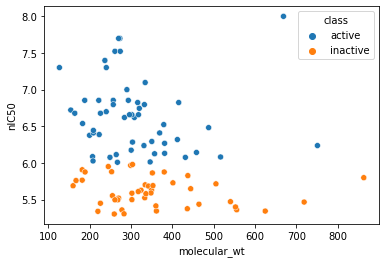

In [47]:
sns.scatterplot(data=df_final, x="molecular_wt", y="nIC50", hue="class")

<AxesSubplot:xlabel='class', ylabel='nIC50'>

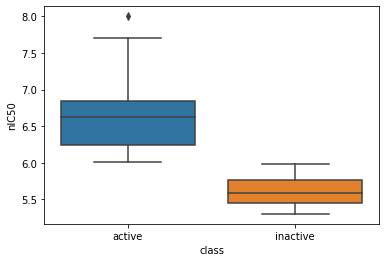

In [50]:
sns.boxplot(x="class", y="nIC50", data=df_final)

### Another Approach of For Other Plot

In [49]:
df_final_mlt = pd.melt(df_final, id_vars=['class'], value_vars=['nIC50', 'logP', 'molecular_wt', 'havy_atom_count',
       'hydrogen_acceptors', 'hydrogen_donors', 'rotatable_bonds',
       'amide_bonds', 'ring_count', 'tpsa', 'hba', 'hbd', 'qed'])

,class,variable,value
0,active,nIC50,6.721246
1,active,nIC50,6.853872
2,inactive,nIC50,5.759451
3,active,nIC50,6.619789
4,active,nIC50,6.008774
...,...,...,...
1282,inactive,qed,0.496772
1283,active,qed,0.591055
1284,inactive,qed,0.500071
1285,inactive,qed,0.335577


# Write CSV

In [44]:
# Write df_final to csv
df_final.to_csv('./output/ml_sars_cov2_mpro.csv')